In [1]:
############################################################
# 
############################################################

# load some bits and pieces
import numpy as np
from numpy.linalg import solve
from numpy.linalg import lstsq
from numpy import log
from numpy import exp

from scipy.optimize import curve_fit

import matplotlib
import matplotlib.pyplot as plt

import CoolProp as CP
from CoolProp.CoolProp import PropsSI

# Check: CoolProp version
print(CP.__version__)
print(CP.__gitrevision__)

# Constants
eps = 1e-3
kilo = 1e3
Mega = 1e6
golden = (1 + 5 ** 0.5) / 2
width = 12.5

6.1.1dev
6d076f9a634cd4b0991d075bb6aa0c0aa29ed8dd


In [2]:
# Set FluidName
FluidName = 'nButane'
AS = CP.AbstractState("HEOS", FluidName)
nPoints = 100

# Constants, triple and critical data
R0 = PropsSI('GAS_CONSTANT',FluidName)
MM = PropsSI('MOLAR_MASS',FluidName)
Rs = R0/MM

T_crt = PropsSI('T_CRITICAL',FluidName)
T_trp = PropsSI('T_TRIPLE',FluidName)
T_max = PropsSI('T_MAX',FluidName)

p_crt = PropsSI('P_CRITICAL',FluidName)
p_trp = PropsSI('P_TRIPLE',FluidName)
p_max = PropsSI('P_MAX',FluidName)

d_crt = PropsSI('RHOMASS_CRITICAL',FluidName)
d_trp_liq = PropsSI('D','T',T_trp,'Q',0,FluidName)
d_trp_vap = PropsSI('D','T',T_trp,'Q',1,FluidName)

v_crt = 1/d_crt
v_trp_liq = 1/d_trp_liq
v_trp_vap = 1/d_trp_vap

h_crt = PropsSI('H','T',T_crt,'D',d_crt,FluidName)
h_trp_liq = PropsSI('H','T',T_trp,'D',d_trp_liq,FluidName)
h_trp_vap = PropsSI('H','T',T_trp,'D',d_trp_vap,FluidName)
h_min = h_trp_liq+6000
h_max = PropsSI('H','T',T_max,'P',p_max,FluidName)

print(FluidName)
print("R0 = " + str(R0))
print("Rs = " + str(Rs))
print("MM = " + str(MM))
print("Rs = " + str(Rs))
print("T_crt = " + str(T_crt))
print("T_trp = " + str(T_trp))

nButane
R0 = 8.314472
Rs = 143.0515706563069
MM = 0.0581222
Rs = 143.0515706563069
T_crt = 425.125
T_trp = 134.895


In [3]:
# set input props
T_sat = 0.7*T_crt
p_sat = PropsSI('P','T',T_sat,'Q',0,FluidName)
h_sat_liq = PropsSI('H','T',T_sat,'Q',0,FluidName)
h_sat_vap = PropsSI('H','T',T_sat,'Q',1,FluidName)
h_iso = h_sat_liq

p_ideal = np.logspace(np.log10(2*p_trp), np.log10(p_crt/1000), num=nPoints)
p_initial = np.logspace(p_crt/500, p_sat, num=nPoints)
#p_dense = np.linspace(p_sat, 0.7*p_max, num=nPoints)
p_dense = np.linspace(p_sat, 1.5*p_crt, num=nPoints)

# pRange = np.concatenate((p_ideal, p_initial, p_dense))
pRange = p_ideal

ss = np.ones(nPoints)
s0s = np.ones(nPoints)
phases = np.ones(nPoints)
cps = np.ones(nPoints)

for idx in range(0,nPoints):
    # ideal gas    
    AS.update(CP.HmassP_INPUTS, h_iso, p_ideal[idx]) 
    s0s[idx] = AS.smass()
    # real gas
    AS.update(CP.HmassP_INPUTS, h_iso, pRange[idx]) 
    ss[idx] = AS.smass()
    phases[idx] = AS.PIP()
    cps[idx] = AS.cpmass()


C:\Users\mthorade\Anaconda3\lib\site-packages\numpy\core\function_base.py:226: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


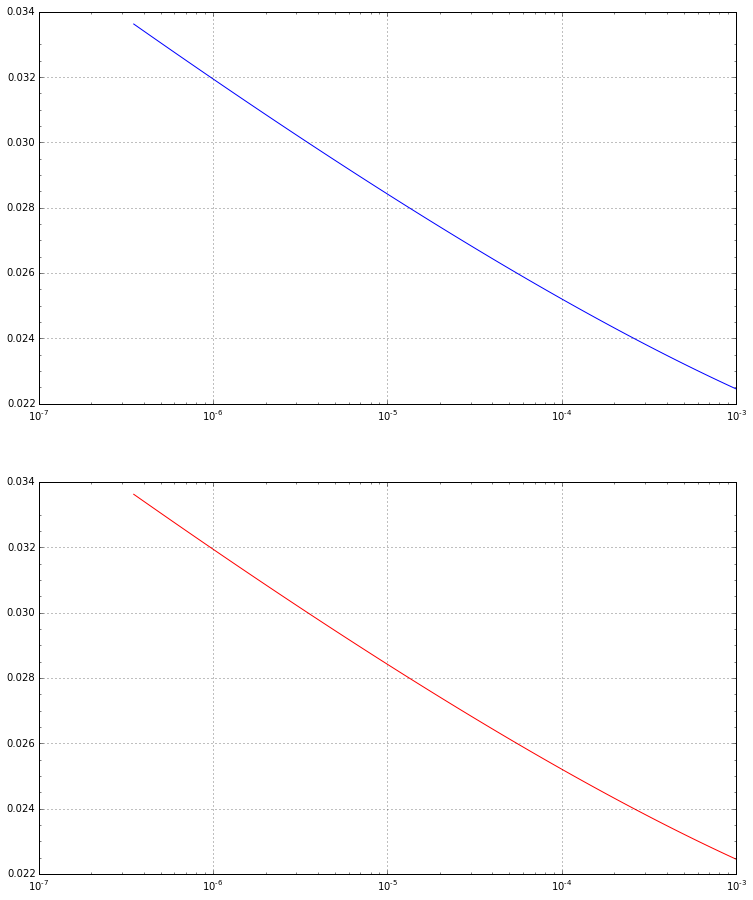

In [42]:
plt.figure(figsize=(width,width*2/1/golden))

plt.subplot(2,1,1)
plt.plot(pRange/p_crt, ss/Rs/T_crt)
plt.xscale('log')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()

plt.subplot(2,1,2)
plt.plot(pRange/p_crt, ss/Rs/T_crt, 'r-')
plt.xscale('log')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()

In [40]:
# functional form definitions
# http://mathworld.wolfram.com/EinsteinFunctions.html
# E4=E2-E3

def line(x, c=[]):
    return -c[0]*log(x)+c[1]

def lineE1(x, a, b):
    return x**2*exp(x)/(exp(x)-1)**2

def lineE2(x, a, b):
    return x/(exp(x)-1)

def lineE3(x, n1, n2, nc):
    return -n1*log(1-exp(-n2*x)) +nc

def lineE4(x, a, b):
    return a*x/(exp(a*x)-1) - log(1-exp(-a*x)) +b

In [41]:
popt, pcov = curve_fit(line, p_ideal/p_crt, s0s/Rs/T_crt)
print(popt)

plt.figure(figsize=(width,width*2/1/golden))

plt.subplot(2,1,1)
plt.plot(pRange/p_crt, ss/Rs/T_crt)
plt.plot(pRange/p_crt, line(pRange/p_crt, popt), 'r-')
plt.xscale('log')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()

plt.subplot(2,1,2)
plt.plot(pRange/p_crt, ss/Rs/T_crt-line(pRange/p_crt, popt), 'r-')
plt.xscale('log')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()

IndexError: invalid index to scalar variable.